In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

# debug cuda
#import os
#os.environ['NUMBA_ENABLE_CUDASIM'] = '1'

import numba
from numba import SmartArray, cuda, float32, int8, int32
from numba.cuda.random import create_xoroshiro128p_states as make_rng_states, xoroshiro128p_uniform_float32 as get_rng
import numpy as np
from IPython import display
from scipy.misc import imshow
from functools import partial
import math
from miniutils import progbar

In [2]:
all_variations = []

class Variation:
    def __init__(self, kind, f):
        self.kind = kind
        self.f = f
        self.func_name = f.__name__
        self.p = None
        
    @property
    def num_p(self):
        return self.kind.num_p
        
    def __call__(self, p=[]):
        assert len(p) <= self.num_p
        p = [p[i] if i < len(p) else 0 for i in range(self.num_p)]
        return cuda.jit(device=True)(self.f(p))
    

class VariationKind:
    def __init__(self, num_p):
        self.num_p = num_p
    
    def __call__(self, f):
        inner_variation_maker = Variation(self, f)
        all_variations.append(inner_variation_maker)
        return inner_variation_maker
    

@VariationKind(0)
def linear(p=[]):
    def f(out_xy, x, y, a, b, c, d, e, f):
        out_xy[0] = x
        out_xy[1] = y
    return f

@VariationKind(0)
def sinusoidal(p=[]):
    def f(out_xy, x, y, a, b, c, d, e, f):
        out_xy[0] = math.sin(x)
        out_xy[1] = math.sin(y)
    return f

@VariationKind(0)
def spherical(p=[]):
    def f(out_xy, x, y, a, b, c, d, e, f):
        r = math.sqrt(x**2 + y**2)
        r = 1 / r**2
        out_xy[0] = r * x
        out_xy[1] = r * y
    return f

@VariationKind(0)
def swirl(p=[]):
    def f(out_xy, x, y, a, b, c, d, e, f):
        r2 = x**2 + y**2
        out_xy[0] = x * math.sin(r2) - y * math.cos(r2)
        out_xy[1] = x * math.cos(r2) + y * math.sin(r2)
    return f

In [3]:
%matplotlib notebook

def plot_variation(var, xmn=-1, xmx=1, xrs=41, ymn=-1, ymx=1, yrs=41):
    from matplotlib import pyplot as plt
    
    @cuda.jit
    def check(an_array):
        thread_id = cuda.grid(1)
        pt = cuda.local.array(2, float32)
        pt[0] = an_array[thread_id, 0]
        pt[1] = an_array[thread_id, 1]
        var(pt, pt[0], pt[1], 1, 1, 1, 1, 1, 1)
        an_array[thread_id, 0] = pt[0]
        an_array[thread_id, 1] = pt[1]
    
    xs = np.linspace(xmn, xmx, xrs)
    ys = np.linspace(ymn, ymx, yrs)
    
    grid_xs, grid_ys = np.meshgrid(xs, ys)
    pts = np.stack([grid_xs.ravel(), grid_ys.ravel()]).T
    
    check[(len(pts),1), 1](pts)
    pts = pts.reshape((xrs, yrs, 2))
    
    
    plt.figure(figsize=(6,6))
    for y in range(yrs):
        plt.plot(pts[:,y,0], pts[:,y,1], c='k')
    for x in range(xrs):
        plt.plot(pts[x,:,0], pts[x,:,1], c='k')
    plt.show()

<IPython.core.display.Javascript object>


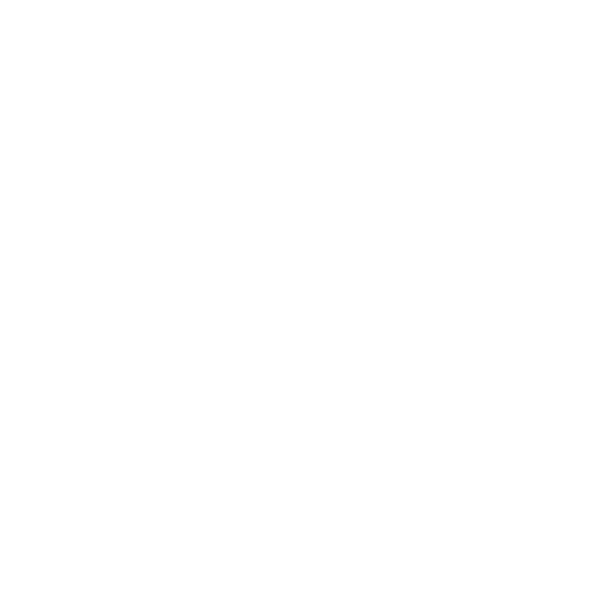

In [4]:
plot_variation(swirl())

In [5]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()


class SimpleTransform:
    def __init__(self):
        self.linear = np.random.normal(size=(2,3))
        
    def make_device_function(self):
        (a, b, c), (d, e, f) = self.linear.astype('float32')
        
        @cuda.jit(device=True)
        def device_transform(xy):
            x = xy[0]
            y = xy[1]
            xy[0] = a * x + b * y + c
            xy[1] = d * x + e * y + f
            
        return device_transform
    


class Transform:
    def __init__(self):
        self.linear = np.random.normal(size=(2,3))
        self.nonlinear_weights = softmax(np.random.normal(size=len(all_variations)))
        self.variations = [var(*np.random.uniform(size=var.kind.num_p)) for var in all_variations]
        self.color = softmax(np.random.uniform(size=3))
        self.post_transform = SimpleTransform()
        
    def make_device_function(self):
        import textwrap
        
        (a, b, c), (d, e, f) = self.linear.astype('float32')
        post_transform_kernel = self.post_transform.make_device_function()
        nonlinear_weights = self.nonlinear_weights.astype('float32')
        variations = tuple(self.variations)
        num_vars = len(self.variations)
        
        run_var = '\n'.join('\t' + line for line in textwrap.dedent("""
        v{j}(variation_cache, lin_x, lin_y, {a}, {b}, {c}, {d}, {e}, {f})
        xy[0] += {w} * variation_cache[0]
        xy[1] += {w} * variation_cache[1]
        """).strip().split('\n'))
        apply_all_variations = [run_var.format(j=j, 
            a=a, b=b, c=c, d=d, e=e, f=f, w=self.nonlinear_weights[j])
                                for j in range(num_vars)]
        apply_all_variations = textwrap.dedent("""
        def apply_variations(xy, variation_cache, lin_x, lin_y):
        {}
        """).strip().format("\n".join(apply_all_variations))
        #print(apply_all_variations)
        glbls = dict(
            {"v{}".format(j): var for j, var in enumerate(variations)}, cuda=cuda
        )
        #print(apply_all_variations)
        exec(apply_all_variations, glbls)
        apply_variations = cuda.jit(device=True)(glbls['apply_variations'])
        
#         for j, var in enumerate(variations):
#             exec("v{j} = variations[{j}]".format(j=j))
#         @cuda.jit(device=True)
#         def apply_variations(xy, variation_cache, lin_x, lin_y):
#             v0(variation_cache, lin_x, lin_y, a, b, c, d, e, f)
#             xy[0] += nonlinear_weights[0] * variation_cache[0]
#             xy[1] += nonlinear_weights[0] * variation_cache[1]
#             v1(variation_cache, lin_x, lin_y, a, b, c, d, e, f)
#             xy[0] += nonlinear_weights[1] * variation_cache[0]
#             xy[1] += nonlinear_weights[1] * variation_cache[1]
#             v2(variation_cache, lin_x, lin_y, a, b, c, d, e, f)
#             xy[0] += nonlinear_weights[2] * variation_cache[0]
#             xy[1] += nonlinear_weights[2] * variation_cache[1]
#             v3(variation_cache, lin_x, lin_y, a, b, c, d, e, f)
#             xy[0] += nonlinear_weights[3] * variation_cache[0]
#             xy[1] += nonlinear_weights[3] * variation_cache[1]
        
        #assert v0 is variations[0]
        assert apply_variations is not None
        
        @cuda.jit(device=True)
        def device_transform(xy):
            variation_cache = cuda.local.array(2, float32)
            lin_x = a * xy[0] + b * xy[1] + c
            lin_y = d * xy[0] + e * xy[1] + f
            xy[:] = 0.0
            variation_cache[:] = 0.0
            #variations[j](variation_cache, lin_x, lin_y, a, b, c, d, e, f)
            apply_variations(xy, variation_cache, lin_x, lin_y)
            post_transform_kernel(xy)
            
        return device_transform

In [6]:
%matplotlib notebook

def plot_transform(trans, xmn=-1, xmx=1, xrs=41, ymn=-1, ymx=1, yrs=41):
    from matplotlib import pyplot as plt
    
    trans = trans.make_device_function()
    @cuda.jit
    def check(an_array):
        thread_id = cuda.grid(1)
        pt = cuda.local.array(2, float32)
        pt[0] = an_array[thread_id, 0]
        pt[1] = an_array[thread_id, 1]
        trans(pt)
        an_array[thread_id, 0] = pt[0]
        an_array[thread_id, 1] = pt[1]
    
    xs = np.linspace(xmn, xmx, xrs)
    ys = np.linspace(ymn, ymx, yrs)
    
    grid_xs, grid_ys = np.meshgrid(xs, ys)
    pts = np.stack([grid_xs.ravel(), grid_ys.ravel()]).T
    
    check[(len(pts),1), 1](pts)
    pts = pts.reshape((xrs, yrs, 2))
    
    
    plt.figure(figsize=(6,6))
    for y in range(yrs):
        plt.plot(pts[:,y,0], pts[:,y,1], c='k')
    for x in range(xrs):
        plt.plot(pts[x,:,0], pts[x,:,1], c='k')
    plt.show()

<IPython.core.display.Javascript object>


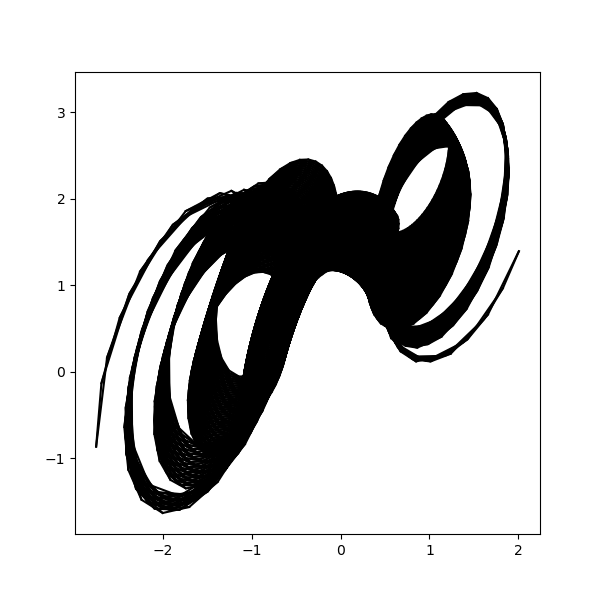

In [7]:
np.random.seed(0)
plot_transform(Transform(), xrs=101, yrs=101)

In [8]:
def make_kernel(num_points, num_steps, transforms, transition_matrix, bounds, resolution, min_step=20, final_transform=None, final_color=None):
    """
    
    :param num_points: Number of points to execute in lock-step in kernel
    :param num_steps: Number of timesteps per point
    :param transforms: [Transform]
    :param transition_matrix: Matrix of transition probabilities from transform i to j
    :param bounds: ((xmin, xmax),(ymin,y_max))
    :param resolution: (xres, yres)
    :param min_step: The first step to actually plot a transformed point
    :returns: A cuda function that will execute the desired function
    :returns: A function that returns the output image that the cuda function writes to
    """
    
    ((xmin, xmax),(ymin, ymax)) = bounds
    xptp = xmax - xmin
    yptp = ymax - ymin
    (xres, yres) = resolution
    num_colors = 4
    _r = 0; _g = 1; _b = 2; _a = 3
    num_transforms = len(transforms)
    
    #cuda_output_image = SmartArray(shape=(num_colors, yres, xres), dtype='float32', where='gpu')
    cuda_output_image = cuda.to_device(np.zeros((num_colors, yres, xres), dtype='float32'))
    transition_matrix = cuda.to_device(transition_matrix)
    return_image = cuda_output_image.copy_to_host
    
    transform_functions = [trans.make_device_function() for trans in transforms]
    transform_colors = cuda.to_device(np.array([trans.color for trans in transforms]))
    
    if final_transform is None:
        final_transform = SimpleTransform()
        final_transform.linear = np.array([[1,0,0],[0,1,0]], dtype='float32')
        final_transform = final_transform.make_device_function()
        
    if final_color is None:
        final_color = (1.0, 1.0, 1.0)
    final_r, final_g, final_b = final_color
    
    def runner(blocks):
        @cuda.jit(device=True)
        def pick_next_transform(current, thread_id, rng_states, transition_matrix):
            rng = get_rng(rng_states, thread_id)
            for i in range(num_transforms):
                if rng <= transition_matrix[current, i]:
                    return i
                rng -= transition_matrix[current, i]
            return 0

        @cuda.jit(device=True)
        def hist(val, vmin, vptp, vres):
            return int32(((val - vmin) / vptp) * vres)

#         @cuda.jit(device=True)
#         def idx(col, ybin, xbin):
#             return col * (xres * yres) + ybin * xres + xbin
        
        dct = {'t{}'.format(i): transform_functions[i] for i in range(len(transforms))}
        code = '''
def call_transform(i, pt):
    if False:
        pass
{}
'''.format('\n'.join('''
    elif i == {i}:
         t{i}(pt)
'''.strip('\n').format(i=i) for i in range(len(transforms)))
        )
        exec(code, dct)
        call_transform = cuda.jit(device=True)(dct['call_transform'])

        @cuda.jit
        def kernel(transform_colors, rng_states, transition_matrix, out):
            thread_id = cuda.grid(1)
            #if thread_id == 0:
            #    from pdb import set_trace; set_trace()

            transform_ids = cuda.shared.array(num_steps, dtype=int8)
            transform_ids[0] = 0
            if cuda.threadIdx.x == 0:
                for i in range(1, num_steps):
                    transform_ids[i] = pick_next_transform(transform_ids[i-1], thread_id, rng_states, transition_matrix)
            cuda.syncthreads()
                    
            pt = cuda.local.array(2, float32)
            pt[0] = get_rng(rng_states, thread_id) * 2 - 1
            pt[1] = get_rng(rng_states, thread_id) * 2 - 1
            r = g = b = 1.0
            final_pt = cuda.local.array(2, float32)

            for i in range(num_steps):
                call_transform(i, pt)
                r = (r + transform_colors[i,_r]) / 2
                g = (g + transform_colors[i,_g]) / 2
                b = (b + transform_colors[i,_b]) / 2

                if i >= min_step:
                    final_pt[0] = pt[0]
                    final_pt[1] = pt[1]
                    final_transform(final_pt)
                    rf = (r + final_r) / 2
                    gf = (g + final_g) / 2
                    bf = (b + final_b) / 2

                    xbin = hist(final_pt[0], xmin, xptp, xres)
                    ybin = hist(final_pt[1], ymin, yptp, yres)
                    cuda.atomic.add(out, (_r, ybin, xbin), rf)
                    cuda.atomic.add(out, (_g, ybin, xbin), gf)
                    cuda.atomic.add(out, (_b, ybin, xbin), bf)
                    cuda.atomic.add(out, (_a, ybin, xbin), 1.0)
                    
        threads_per_block = num_points
        rng_states = make_rng_states(threads_per_block * blocks, seed=0)
        kernel[(blocks,), threads_per_block](transform_colors, rng_states, transition_matrix, cuda_output_image)
                
    return runner, return_image

<IPython.core.display.Javascript object>


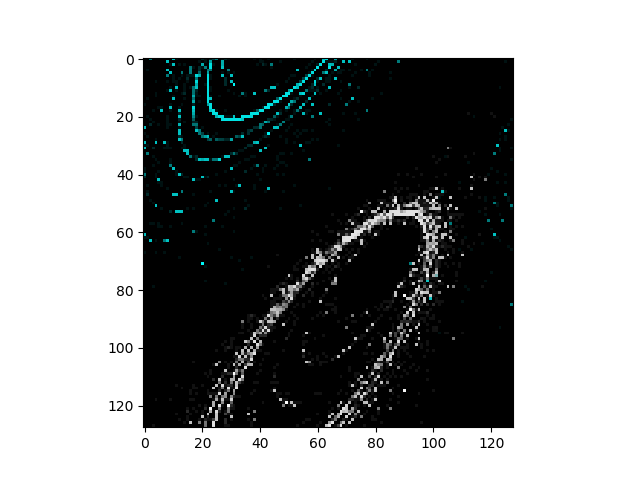

HBox(children=(IntProgress(value=0), HTML(value='')))

In [9]:
np.random.seed(0)
transforms = [Transform() for _ in range(10)]
transition_matrix = np.random.normal(size=(10,10))
transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)
kernel, get_img = make_kernel(10, 10000, transforms, transition_matrix, ((-5,5),(-5,5)), (128, 128), min_step=20)

plt.figure()
for i in progbar(100):
    kernel(1000)
    r, g, b, a = get_img()
    #print(np.sum(a))
    im = np.stack([r,g,b], axis=-1)
    #print(im.shape)
    plt.imshow(np.log1p(im), interpolation='nearest')
    plt.show()
    plt.gcf().canvas.draw()

In [ ]:
@cuda.jit
def increment_by_one(an_array):
    pos = cuda.grid(1)
    if pos < an_array.size:
        an_array[pos] += 1
        
        
an_array = np.arange(16 * 16 * 2)
threadsperblock = (16, 16)
blockspergrid = len(an_array) // (np.prod(threadsperblock))
increment_by_one[(blockspergrid,1), threadsperblock](an_array)
print(an_array[0:5])

In [ ]:
@cuda.jit(device=True)
def ones(arr):
    arr[0] = 1.0
    arr[1] = 1.0

@cuda.jit
def do_something(an_array):
    pos = cuda.grid(1)
    cache = cuda.local.array(2, float32)
    ones(cache)
    an_array[pos] += cache[0] + cache[1]


an_array = np.arange(16 * 16 * 2, dtype='float32')
threadsperblock = (16, 16)
blockspergrid = len(an_array) // (np.prod(threadsperblock))
do_something[(blockspergrid,1), threadsperblock](an_array)
print(an_array[0:5])
print(ones)

In [ ]:
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def compute_pi(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    thread_id = cuda.grid(1)

    # Compute pi by drawing random (x, y) points and finding what
    # fraction lie inside a unit circle
    inside = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x**2 + y**2 <= 1.0:
            inside += 1

    out[thread_id] = 4.0 * inside / iterations

threads_per_block = 64
blocks = 24
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

compute_pi[blocks, threads_per_block](rng_states, 10000, out)
print('pi:', out.mean())